In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tnrange

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp


sns.set_context('paper', font_scale=1.5)

# Load all of the data.
The datafiles for the simulations are large and not saved to the repository for this reason. They've been seeded for replicability and can be rerun with the following scripts:

1) To regenerate these simultions, run the script 
`batch_run_generative_models.py`

2) To concatenate the datasets:
`merge_dataframes.py`

Note that the simulations will take several hours (up to a day) on a modern laptop.



In [2]:
tag = '_update_all_trials_gp=1e-10_prune=100_mu=-0.5'

In [3]:
# load experiment 2 goals
sims_exp_2 = pd.read_pickle('exp_2_goals_batch_of_sims{}.pkl'.format(tag))
sims_exp_2['Training'] = sims_exp_2.Context <= 2
sims_exp_2['Acc'] = pd.to_numeric(sims_exp_2.Reward)

In [4]:
# load experiment 4 goals
sims_exp_4 = pd.read_pickle('exp_4_goals_batch_of_sims{}.pkl'.format(tag))
sims_exp_4['Training'] = sims_exp_4.Context < 9
sims_exp_4['Acc'] = pd.to_numeric(sims_exp_4.Reward)

In [5]:
# load experiment 3 goals
sims_exp_3 = pd.read_pickle('exp_3_goals_batch_of_sims{}.pkl'.format(tag))
sims_exp_3['Training'] = sims_exp_3.Context < 7
sims_exp_3['Acc'] = pd.to_numeric(sims_exp_3.Reward)

In [6]:
# General helper function
def reduce_range(df, list_iterations):
    new_df = [None] * len(list_iterations)
    for subj in list_iterations:
        new_df.append(df.loc[df.Iteration == subj, :])
    return pd.concat(new_df)

def draw_batch(df, batch_size=114):
    iterations = np.array(list(set(df.Iteration)))
    n_batches = len(set(df[u'Iteration']))
    sampled_iteration = set()
    while len(sampled_iteration) < batch_size:
        sampled_iteration.add(iterations[np.random.randint(0, n_batches)])
    sampled_iteration = list(sampled_iteration)
    return reduce_range(df, sampled_iteration)

def get_diff_stats(score, idx=0):
    """
    score: pandas.DataFrame with the comparions precomputed
    """
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    stats_output = []
    for m in set(diff.Model):
        for c in set(score.Comparison):
            selection = (diff.Model == m) &(diff.Comparison == c)
            t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
            df = len(diff.loc[selection, 'Difference Score'].values) - 1
            M = np.mean(diff.loc[selection, 'Difference Score'].values)
            d = M / np.std(diff.loc[selection, 'Difference Score'].values)
            
            stats_output.append({
                'Model': m,
                'Sample': idx,
                'Comparison': c,
                'Mean': M,
                'd-prime': d,
                't-statistic': t,
                'p-value': p,
                'df': df,
            })
    return stats_output

# construct the 95% HDI for the means
def get_hdi(unsorted_values, hdi=0.95):
    tail = (1. - hdi) / 2
    sorted_values = np.sort(unsorted_values)
    lb = sorted_values[int(np.floor(sorted_values.shape[0] * tail))]
    ub = sorted_values[int(np.ceil(sorted_values.shape[0] * (1 - tail)))]
    return lb, ub
    



# Experiment 1: Joint Structure

In [7]:
# experiment 2 goals
def draw_exp_2_sample():
    n_task_a = 49
    n_task_b = 80

    # sampled_batch = draw_batch(sims_exp_2, batch_size=n_task_b)

    # the sample sizes of task A and task B are uneven in the subject pool,
    # reduce the sample accordingly
    b_sample = draw_batch(sims_exp_2[sims_exp_2.Task == 'B'],  batch_size=n_task_b)
    a_sample = draw_batch(sims_exp_2[sims_exp_2.Task == 'A'],  batch_size=n_task_a)

    return pd.concat([b_sample, a_sample])

def score_experiment_2(sampled_batch, idx):
    sampled_batch0 = sampled_batch[
        (~sampled_batch.Training) & (sampled_batch['Times Seen Context'] <= 4)
    ].copy()
    sampled_batch0['Correct Goal'] = ['A'] * len(sampled_batch0)
    sampled_batch0.loc[sampled_batch0.Context == 5, 'Correct Goal'] = 'B'
    grouped = sampled_batch0.groupby(['Model', 'Task', 'Correct Goal'])
    scored = grouped.mean()['Acc'].reset_index()
    scored['Sample'] = idx
    return scored



In [8]:
from tqdm import tnrange
stats_exp_2_goals = []
for ii in tnrange(100):
    stats_exp_2_goals.append(score_experiment_2(draw_exp_2_sample(), ii))
stats_exp_2_goals = pd.concat(stats_exp_2_goals)



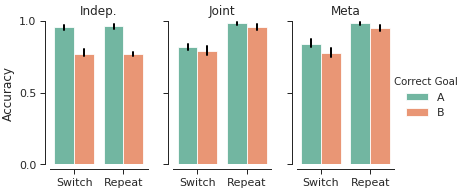

In [247]:
with sns.axes_style('ticks'):
    g = sns.catplot(
        hue='Correct Goal', y='Acc', data=stats_exp_2_goals[stats_exp_2_goals.Model != 'Flat'],
        kind='bar', col='Model',
        x='Task',  hue_order=['A', 'B'], ci=None,
        palette='Set2', height=3.0, aspect=0.63, estimator=np.median,
    )
    sns.despine(offset=5)

    g.set_xticklabels('Switch Repeat'.split())
    g.set_xlabels('')
    g.set_ylabels('Accuracy')
    g.axes[0][0].set_yticks(np.arange(0, 1.01, 0.5))
    g.axes[0][0].set_ylim(0.0, 1)

    g.axes[0][0].set_title('Indep.')
    g.axes[0][1].set_title('Joint')
    g.axes[0][2].set_title('Meta')
    
    # plot the error bars
    def _plot_hdi(model, ax):
        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'A') & 
            (stats_exp_2_goals['Correct Goal'] == 'A')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([-0.2, -0.2], [lb, ub], lw=2, color='k')
        
        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'A') & 
            (stats_exp_2_goals['Correct Goal'] == 'B')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([0.2, 0.2], [lb, ub], lw=2, color='k')

        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'B') & 
            (stats_exp_2_goals['Correct Goal'] == 'A')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([0.8, 0.8], [lb, ub], lw=2, color='k')
        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'B') & 
            (stats_exp_2_goals['Correct Goal'] == 'B')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([1.2, 1.2], [lb, ub], lw=2, color='k')
        
    _plot_hdi('Independent', g.axes[0][0])
    _plot_hdi('Joint', g.axes[0][1])
    _plot_hdi('Meta', g.axes[0][2])
    plt.savefig('exp_2_goals_fig_models.png', dpi=300, bbox_inches='tight')

In [10]:
# get statistics on the simple effects
model = 'Independent'

def hdi_main_effect_task(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'B') ,'Acc'].values
    return get_hdi(v1 - v0)

def hdi_main_effect_goal(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'B') ,'Acc'].values
    return get_hdi(v0 - v1)

print 'Independent (task): {}'.format(hdi_main_effect_task('Independent'))
print 'Independent (goal): {}'.format(hdi_main_effect_goal('Independent'))
print
print 'Joint (task): {}'.format(hdi_main_effect_task('Joint'))
print 'Joint (goal): {}'.format(hdi_main_effect_goal('Joint'))
print
print 'Meta (task): {}'.format(hdi_main_effect_task('Meta'))
print 'Meta (goal): {}'.format(hdi_main_effect_goal('Meta'))

Independent (task): (-0.028188775510204156, 0.02586096938775506)
Independent (goal): (0.15051020408163274, 0.21562499999999996)

Joint (task): (0.13762755102040813, 0.20392219387755106)
Joint (goal): (-0.005102040816326481, 0.061224489795918324)

Meta (task): (0.12139668367346934, 0.19604591836734697)
Meta (goal): (0.018750000000000044, 0.09183673469387754)


# Experiment 2: Independent Structure

In [11]:
def get_hdi_exp4goals(df, model, comparison, hdi=0.95):
    v = df.loc[(df.Model==model) & (df.Comparison == comparison), 'Mean'].values
    return get_hdi(v, hdi)

def get_mean_exp_4_goals(df, model, comparison, hdi=0.95):
    tail = (1. - hdi) / 2
    v = df.loc[(df.Model==model) & (df.Comparison == comparison), 'Mean'].values
    return v.mean()

def score_experiment_4_goals(sampled_batch):
  
    df0 = sampled_batch[sampled_batch['In Goal'] 
                  & (sampled_batch.Context >= 7) 
                  & (sampled_batch['Model'] != 'Flat')
                 ].copy()
    
    score = list()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]


            a = (subj_df.Context == 7)
            b = (subj_df.Context == 8) | (subj_df.Context == 10)
            diff_1 = subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 7) | (subj_df.Context == 8)
            b = (subj_df.Context == 9) | (subj_df.Context == 10)
            diff_2 =subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 9)
            b = (subj_df.Context == 10)
            diff_3 = \
                subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']


            n = len(diff_1)
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T1 vs T2'] * n,
                        'Difference Score': diff_1,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T1+2 vs T3+4'] * n,
                        'Difference Score': diff_2,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T3 vs T4'] * n,
                        'Difference Score': diff_3,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))

    return pd.concat(score) 



In [12]:
stats_exp_4_goals = []

n_batches = 100
hdi_interval = 0.95

goal_counts_exp_4_goals = []

for ii in tnrange(n_batches):
    batched_data = draw_batch(sims_exp_4, batch_size=114)
    
    # count the goals tried in the first trial of each test context
    gcd = batched_data[batched_data['In Goal'] & (batched_data.Context > 6) & 
                   (batched_data['Times Seen Context'] == 1) 
                 & (batched_data['Model'] != 'Flat')].copy()
    gcd['Map'] = ['1'] * len(gcd)
    gcd.loc[(gcd.Context == 7) | (gcd.Context == 8), 'Map'] = 1
    gcd.loc[(gcd.Context == 9) | (gcd.Context == 10), 'Map'] = 2
    gcd['Sample'] = ii

    # Because "In Goal" is a boolean that is always true here, we count that
    goal_counts_exp_4_goals.append(
        gcd.groupby(['Model', 'Map', 'Chosen Goal']).count()['In Goal'].reset_index()
    )
    
    
    # get the difference scores
    scored = score_experiment_4_goals(batched_data)
    stats_exp_4_goals += get_diff_stats(scored, idx=ii)
    
stats_exp_4_goals = pd.DataFrame(stats_exp_4_goals)
goal_counts_exp_4_goals = pd.concat(goal_counts_exp_4_goals)

In [13]:
stats_exp_4_goals['Power'] = (stats_exp_4_goals['p-value'].copy() < 0.05)
stats_exp_4_goals.groupby(['Model', 'Comparison']).mean()

Mean  Sample   d-prime     df       p-value  \
Model       Comparison                                                      
Independent T1 vs T2      0.237251    49.5  0.747865  113.0  8.308277e-08   
            T1+2 vs T3+4  0.233385    49.5  0.853145  113.0  1.413676e-09   
            T3 vs T4     -0.002851    49.5 -0.008547  113.0  4.959932e-01   
Joint       T1 vs T2      0.006703    49.5  0.020930  113.0  5.029914e-01   
            T1+2 vs T3+4  0.099803    49.5  0.382690  113.0  2.844674e-03   
            T3 vs T4     -0.157310    49.5 -0.422067  113.0  1.116493e-03   
Meta        T1 vs T2      0.104437    49.5  0.334543  113.0  1.178204e-02   
            T1+2 vs T3+4  0.171769    49.5  0.674636  113.0  6.033251e-06   
            T3 vs T4     -0.111053    49.5 -0.309571  113.0  9.040563e-03   

                          t-statistic  Power  
Model       Comparison                        
Independent T1 vs T2         7.949918   1.00  
            T1+2 vs T3+4     9.069051   1.00  
            T3 vs T4        -0.090851   0.03  
Joint       T1 vs T2         0.222493   0.05  
            T1+2 vs T3+4     4.068045   0.99  
            T3 vs T4        -4.486631   1.00  
Meta        T1 vs T2         3.556243   0.93  
            T1+2 vs T3+4     7.171481   1.00  
            T3 vs T4        -3.290784   0.96

In [14]:
hdi = []
for comparison in set(stats_exp_4_goals.Comparison):
    for model in set(stats_exp_4_goals.Model):
        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, comparison, hdi=hdi_interval)
        hdi.append({
            'Comparison': comparison,
            'Model': model,
            'Mean': get_mean_exp_4_goals(stats_exp_4_goals, model, comparison),
            'Lower Bound': lb,
            'Upper Bound': ub
        })
hdi_data_exp_4_goals = pd.DataFrame(hdi)

In [15]:
hdi_data_exp_4_goals

,Comparison,Lower Bound,Mean,Model,Upper Bound
0,T1 vs T2,0.175439,0.237251,Independent,0.298977
1,T1 vs T2,0.045322,0.104437,Meta,0.164474
2,T1 vs T2,-0.054094,0.006703,Joint,0.064327
3,T3 vs T4,-0.065789,-0.002851,Independent,0.049708
4,T3 vs T4,-0.165205,-0.111053,Meta,-0.054094
5,T3 vs T4,-0.229532,-0.157310,Joint,-0.078947
6,T1+2 vs T3+4,0.177632,0.233385,Independent,0.288743
7,T1+2 vs T3+4,0.128655,0.171769,Meta,0.214181
8,T1+2 vs T3+4,0.054094,0.099803,Joint,0.145468


In [101]:
sns.set_context('paper', font_scale=1.75)
def plot_contrasts_exp_4_goals(model, model_name, hdi=0.95):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(1.0, 2.5))  
        sns.barplot(x='Comparison', y='Mean', 
                data=hdi_data_exp_4_goals[hdi_data_exp_4_goals.Model == model], color='skyblue', ax=ax, 
                    order=['T1 vs T2', 'T1+2 vs T3+4', 'T3 vs T4'])
        ax.set_ylabel(r'Difference Score', labelpad=-3)
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        ax.set_xlim([-0.5, 2.5])
        ax.set_yticks(np.arange(-0.2, 0.35, 0.1))
        ax.set_ylim([-0.2, 0.35])
        sns.despine(offset=5)
        
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        
        def plot_stars(x0):
            ax.annotate("*", xy=(x0-0.29, 0.28), size=22)
        
        # plot the error bars
        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T1 vs T2', hdi)
        ax.plot([0, 0],[lb, ub], 'k')
        if np.sign(lb) == np.sign(ub):
            plot_stars(0)
        
        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T1+2 vs T3+4', hdi)
        ax.plot([1, 1],[lb, ub], 'k')
        if np.sign(lb) == np.sign(ub):
            plot_stars(1)

        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T3 vs T4', hdi)
        ax.plot([2, 2],[lb, ub], 'k')
        if np.sign(lb) == np.sign(ub):
            plot_stars(2)
        
        ax.set_title(model_name)
        return fig, ax



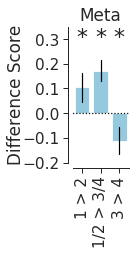

In [102]:
fig, _ = plot_contrasts_exp_4_goals('Meta', 'Meta', hdi=hdi_interval)
fig.savefig('exp_4_goals_model_meta.png', dpi=300, bbox_inches='tight')

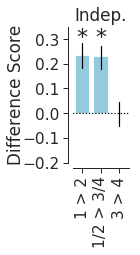

In [103]:
fig, _ = plot_contrasts_exp_4_goals('Independent', 'Indep.', hdi=0.9)
fig.savefig('exp_4_goals_model_indep.png', dpi=300, bbox_inches='tight')

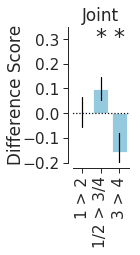

In [104]:
fig, _ = plot_contrasts_exp_4_goals('Joint', 'Joint', hdi=hdi_interval)
fig.savefig('exp_4_goals_model_joint.png', dpi=300, bbox_inches='tight')

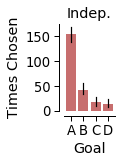

In [106]:
sns.set_context('paper', font_scale=1.5)
def plot_counts(model, title, map_, hdi=0.95):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    if map_ == 2:
        c = sns.color_palette('muted')[3]
    else:
        c = sns.color_palette('muted')[0]
    
    df0 = goal_counts_exp_4_goals[
        (goal_counts_exp_4_goals.Model == model) & (goal_counts_exp_4_goals.Map == map_)
    ]
        
    sns.barplot(x="Chosen Goal", y="In Goal", order='A B C D'.split(),
                data=df0, ax=ax, color=c, ci=None)
    
    # get the HDI for each of the counts
    for x, g in enumerate('A B C D'.split()):
        lb, ub = get_hdi(df0.loc[df0['Chosen Goal'] == g, 'In Goal'].values, hdi)
        ax.plot([x, x],[lb, ub], 'k')


    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(title)
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])

    sns.despine(offset=5)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
plot_counts('Independent', 'Indep.', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_indep_2.png', dpi=300, bbox_inches='tight')

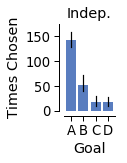

In [107]:
plot_counts('Independent', 'Indep.', map_=1, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_indep_3.png', dpi=300, bbox_inches='tight')

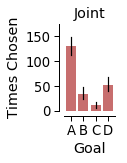

In [108]:
plot_counts('Joint', 'Joint', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_joint_2.png', dpi=300, bbox_inches='tight')

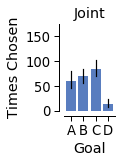

In [109]:
plot_counts('Joint', 'Joint', map_=1, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_joint_3.png', dpi=300, bbox_inches='tight')

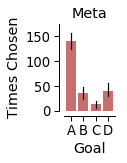

In [110]:
plot_counts('Meta', 'Meta', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_meta_2.png', dpi=300, bbox_inches='tight')

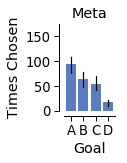

In [111]:
plot_counts('Meta', 'Meta', map_=1, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_meta_3.png', dpi=300, bbox_inches='tight')

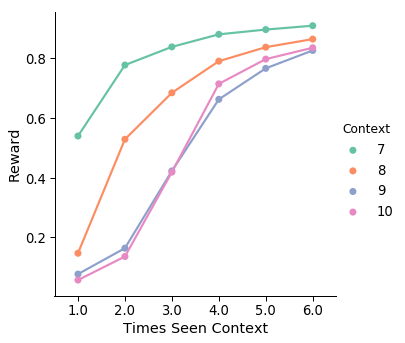

In [112]:
sns.catplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
              data=sims_exp_4[(sims_exp_4.Model=='Independent')&
                                    (sims_exp_4['In Goal']) & 
                                    (sims_exp_4['Context'] >=7)],  palette='Set2', kind='point')

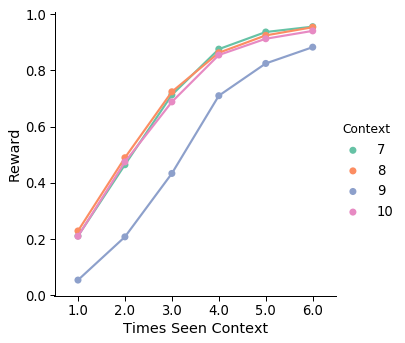

In [113]:
sns.catplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
              data=sims_exp_4[(sims_exp_4.Model=='Joint')&
                                    (sims_exp_4['In Goal']) & 
                                    (sims_exp_4['Context'] >=7)],  palette='Set2', kind='point')

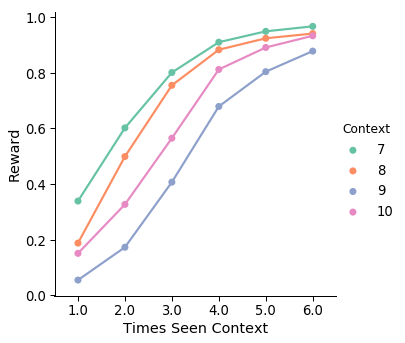

In [114]:
sns.catplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
              data=sims_exp_4[(sims_exp_4.Model=='Meta')&
                                    (sims_exp_4['In Goal']) & 
                                    (sims_exp_4['Context'] >=7)],  palette='Set2', kind='point')

# Experiment 3: Ambigous Enviornment (3 Goals)

In [29]:
def score_experiment_3_goals(sampled_batch):
  
    df0 = sampled_batch[
            sampled_batch['In Goal'] & 
            (sampled_batch.Context > 4) & 
            (sampled_batch['Times Seen Context'] <= 5) &
            (sampled_batch['Model'] != 'Flat')
             ].copy()

    
    score = list()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]

            a = (subj_df.Context == 5)
            b = (subj_df.Context == 8) 
            diff_1 = subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 6)
            b = (subj_df.Context == 7) 
            diff_2 =subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 5) | (subj_df.Context == 8)
            b = (subj_df.Context == 6) | (subj_df.Context == 7)
            diff_3 = \
                subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']
            
#             diff_1 = subj_df.loc[subj_df.Context == 5, :].groupby('Times Seen Context').mean()['Acc'] - \
#                 subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

#             diff_2 = subj_df.loc[(subj_df.Context == 7), :].groupby('Times Seen Context').mean()['Acc'] - \
#                 subj_df.loc[(subj_df.Context == 6) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

#             diff_3 = subj_df.loc[subj_df.Context == 6, :].groupby('Times Seen Context').mean()['Acc'] - \
#                 subj_df.loc[(subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc']

            n = len(diff_1)
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T1 vs T4'] * n,
                        'Difference Score': diff_1,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T2 vs T3'] * n,
                        'Difference Score': diff_2,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T1/4 vs T2/3'] * n,
                        'Difference Score': diff_3,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))

    return pd.concat(score) 

In [30]:

n_batches = 100
hdi_interval = 0.95

stats_exp_3_goals = []


for ii in tnrange(n_batches):
    batched_data = draw_batch(sims_exp_3, batch_size=114)

    
    # get the difference scores
    scored = score_experiment_3_goals(batched_data)
    stats_exp_3_goals += get_diff_stats(scored, idx=ii)
    
stats_exp_3_goals = pd.DataFrame(stats_exp_3_goals)


In [32]:
hdi_data_exp_3_goals = []
for comparison in set(stats_exp_3_goals.Comparison):
    for model in set(stats_exp_3_goals.Model):
        # can use the function from exp_4_goals without modification
        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, comparison, hdi=hdi_interval)
        hdi_data_exp_3_goals.append({
            'Comparison': comparison,
            'Model': model,
            'Mean': get_mean_exp_4_goals(stats_exp_3_goals, model, comparison),  # don't need to rewrite function
            'Lower Bound': lb,
            'Upper Bound': ub
        })
hdi_data_exp_3_goals = pd.DataFrame(hdi_data_exp_3_goals)

In [117]:
def plot_contrasts_exp_3_goals(model, model_name, hdi=0.95):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(1.0, 2.5))  
        sns.barplot(x='Comparison', y='Mean', 
                data=hdi_data_exp_3_goals[hdi_data_exp_3_goals.Model == model], color='skyblue', ax=ax, 
                    order=['T1 vs T4', 'T2 vs T3', 'T1/4 vs T2/3'])
        ax.set_ylabel(r'Difference Score', labelpad=-3)
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        ax.set_xlim([-0.5, 2.5])
        ax.set_ylim([-.2, .25])
        ax.set_yticks(np.arange(-0.1, 0.351, 0.1))
        sns.despine(offset=5)
        
        plt.xticks([0, 1, 2], [r'1 > 4', u'2 > 3', r'1/4 > 2/3' ], rotation='vertical')
        
        # plot the error bars (don't need to re-write function here)
        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T1 vs T4', hdi)
        ax.plot([0, 0],[lb, ub], 'k')
        def plot_stars(x0):
            ax.annotate("*", xy=(x0-0.29, 0.25), size=22)
        if np.sign(lb) == np.sign(ub):
            plot_stars(0)
        
        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T2 vs T3', hdi)
        ax.plot([1, 1],[lb, ub], 'k')
        if np.sign(lb) == np.sign(ub):
            plot_stars(1)

        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T1/4 vs T2/3', hdi)
        ax.plot([2, 2],[lb, ub], 'k')
        if np.sign(lb) == np.sign(ub):
            plot_stars(2)
        
        ax.set_title(model_name)
        return fig, ax

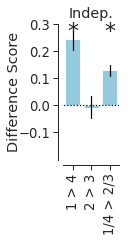

In [118]:
fig, _ = plot_contrasts_exp_3_goals('Independent', 'Indep.', hdi=hdi_interval)
fig.savefig('exp_3_goals_model_indep.png', dpi=300, bbox_inches='tight')

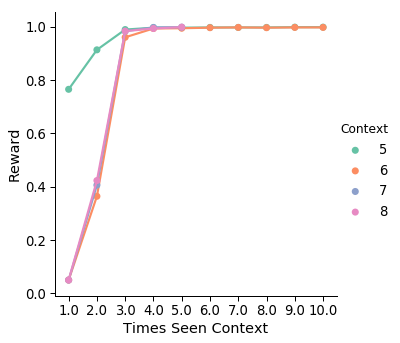

In [119]:
sns.catplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
              data=sims_exp_3[(sims_exp_3.Model=='Independent')&
                                    (sims_exp_3['In Goal']) & 
                                    (sims_exp_3['Context'] >=5)],  palette='Set2', kind='point')

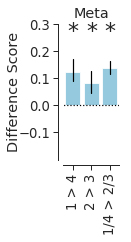

In [120]:
fig, _ = plot_contrasts_exp_3_goals('Meta', 'Meta', hdi=hdi_interval)
# print get_hdi_exp4goals(stats_exp_3_goals, 'Meta', 'T3 vs T2/4', hdi=0.95)
fig.savefig('exp_3_goals_model_meta.png', dpi=300, bbox_inches='tight')

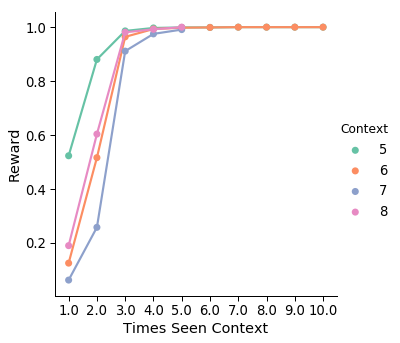

In [121]:
sns.catplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
              data=sims_exp_3[(sims_exp_3.Model=='Meta')&
                                    (sims_exp_3['In Goal']) & 
                                    (sims_exp_3['Context'] >=5)],  palette='Set2', kind='point')

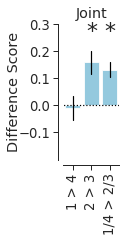

In [122]:
fig, _ = plot_contrasts_exp_3_goals('Joint', 'Joint', hdi=hdi_interval)
fig.savefig('exp_3_goals_model_joint.png', dpi=300, bbox_inches='tight')

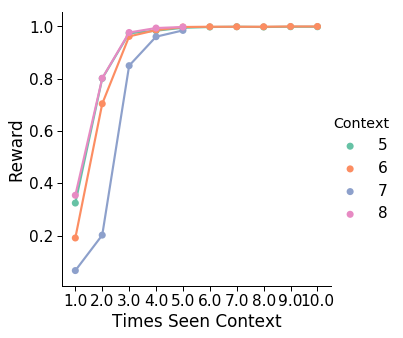

In [39]:
sns.catplot(x='Times Seen Context', hue='Context', y='Reward', ci=None,
              data=sims_exp_3[(sims_exp_3.Model=='Joint')&
                                    (sims_exp_3['In Goal']) & 
                                    (sims_exp_3['Context'] >=5)],  palette='Set2', kind='point')

# Meta-Agent Comparison

In [40]:
meta_agent_prob = []
for ii in tnrange(100):
    sample_exp_4_goals = draw_batch(sims_exp_4, batch_size=114)
    sample_exp_2_goals = draw_exp_2_sample()
    sample_exp_3_goals = draw_batch(sims_exp_3, batch_size=115)


    meta_2goals = sample_exp_2_goals[(sample_exp_2_goals['Model'] == 'Meta') & sample_exp_2_goals['In Goal']]
    meta_3goals = sample_exp_3_goals[(sample_exp_3_goals['Model'] == 'Meta') & sample_exp_3_goals['In Goal']]
    meta_4goals = sample_exp_4_goals[(sample_exp_4_goals['Model'] == 'Meta') & sample_exp_4_goals['In Goal']]
    
    meta_agent_prob.append({
    'Sample': ii,
    'Exp 1': meta_2goals.loc[meta_2goals['Trial Number'] == 18, 'Joint Probability'].mean(),
    'Exp 2': meta_4goals.loc[meta_4goals['Trial Number'] == 160, 'Joint Probability'].mean(),
    'Exp 3': meta_3goals.loc[meta_3goals['Trial Number'] == 120, 'Joint Probability'].mean(),
    })

In [41]:
meta_agent_prob = pd.DataFrame(meta_agent_prob)

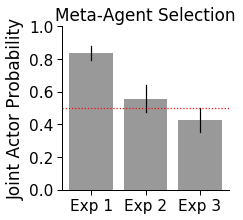

In [48]:
y = meta_agent_prob.mean().loc[['Exp 1', 'Exp 2', 'Exp 3']]
fig, ax = plt.subplots(figsize=(3, 3))
plt.bar(range(3), y, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
sns.despine()

lb, ub = get_hdi(meta_agent_prob['Exp 1'])
plt.plot([0, 0], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 2'])
plt.plot([1, 1], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 3'])
plt.plot([2, 2], [lb, ub], 'k')

ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
ax.set_ylabel('Joint Actor Probability')
sns.despine()
plt.title('Meta-Agent Selection')
plt.savefig('Meta_agents_prob_training_end.png', dpi=300, bbox_inches='tight')

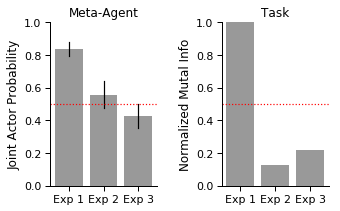

In [139]:
# repeat, but with NMI included
sns.set_context('paper', font_scale=1.25)
y = meta_agent_prob.mean().loc[['Exp 1', 'Exp 2', 'Exp 3']]
fig, axes = plt.subplots(1, 2, figsize=(5, 3), gridspec_kw=dict(wspace=0.6))
ax = axes[0]
plt.sca(ax)
plt.bar(range(3), y, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
sns.despine()

lb, ub = get_hdi(meta_agent_prob['Exp 1'])
plt.plot([0, 0], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 2'])
plt.plot([1, 1], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 3'])
plt.plot([2, 2], [lb, ub], 'k')

ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
ax.set_ylabel('Joint Actor Probability')
sns.despine()
plt.title('Meta-Agent')

ax = axes[1]
plt.sca(ax)
nmi = [1.0, 0.126, 0.22]
plt.bar(range(3), nmi, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
ax.set_ylabel('Normalized Mutal Info')
ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
plt.title('Task')


plt.savefig('Meta_agents_prob_training_end_NMI.png', dpi=300, bbox_inches='tight')

## Training Accuracy
Bootstrap statistics for training accuracy across experiments

In [179]:
train_acc_2_g = sims_exp_2.loc[sims_exp_2['In Goal'] & (sims_exp_2['Context'] < 3), :].groupby(
    ['Model', 'Iteration']).mean()['Acc']
train_acc_3_g = sims_exp_3.loc[sims_exp_3['In Goal'] & (sims_exp_3['Context'] < 7), :].groupby(
    ['Model', 'Iteration']).mean()['Acc']
train_acc_4_g = sims_exp_4.loc[sims_exp_4['In Goal'] & (sims_exp_4['Context'] < 9), :].groupby(
    ['Model', 'Iteration']).mean()['Acc']



In [180]:
def draw_bootstrap_sample_acc_2g(model):
    idx = np.random.permutation(range(2000))[:49 + 80]
    return np.mean(train_acc_2_g.loc[model, idx].values)

def draw_bootstrap_sample_acc_3g(model):
    idx = np.random.permutation(range(1000))[:114]
    return np.mean(train_acc_3_g.loc[model, idx].values)

def draw_bootstrap_sample_acc_4g(model):
    idx = np.random.permutation(range(1000))[:115]
    return np.mean(train_acc_4_g.loc[model, idx].values)

In [229]:
training_acc = []
for ii in range(100):
    for m in [u'Flat', u'Independent', u'Joint', u'Meta']:
        training_acc.append({
            'Model': m,
            'Experiment': 'Exp 1',
            'Accuracy': draw_bootstrap_sample_acc_2g(m),
            'Iteration': ii,
        })
        training_acc.append({
            'Model': m,
            'Experiment': 'Exp 2',
            'Accuracy': draw_bootstrap_sample_acc_4g(m),
            'Iteration': ii,
        })
        training_acc.append({
            'Model': m,
            'Experiment': 'Exp 3',
            'Accuracy': draw_bootstrap_sample_acc_3g(m),
            'Iteration': ii,
        })
training_acc = pd.DataFrame(training_acc) 

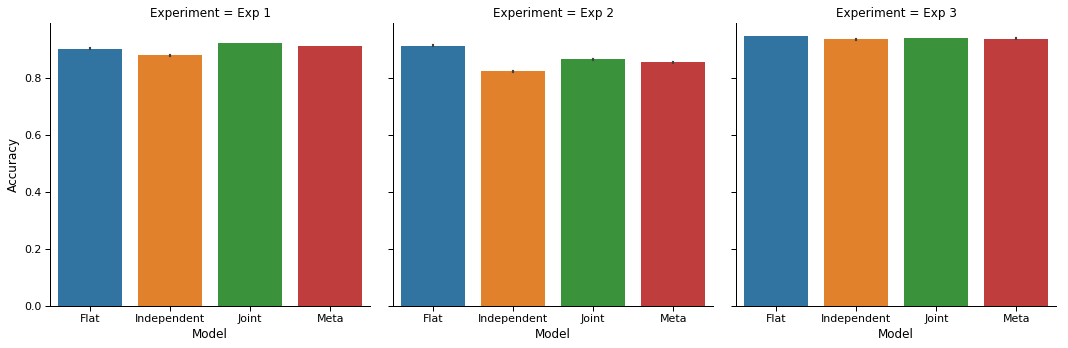

In [230]:
sns.catplot(data=training_acc, y='Accuracy', x='Model', col='Experiment', kind='bar',)

Indep Mean=-0.0235174418605, 95% HDI = [-0.0368217054264, -0.00581395348837]
Joint Mean=0.020242248062, 95% HDI = [0.0077519379845, 0.0343992248062]
Meta  Mean=0.00941375968992, 95% HDI = [-0.00387596899225, 0.0227713178295]


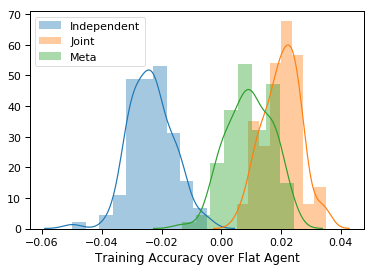

In [244]:
# Experiment 1
sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Independent')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Joint')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Meta'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Meta')
plt.legend()
plt.xlabel("Training Accuracy over Flat Agent")

d_i = training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_j = training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_m = training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Meta'), 'Accuracy'].values -\
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values
# print p_i, p_j, p_m
d_i.sort()
d_j.sort()
d_m.sort()

n = len(d_i)
print "Indep Mean={}, 95% HDI = [{}, {}]".format(d_i.mean(), d_i[int(np.floor(n * 0.025))], d_i[int(np.ceil(n * 0.975))]) 
print "Joint Mean={}, 95% HDI = [{}, {}]".format(d_j.mean(),d_j[int(np.floor(n * 0.025))], d_j[int(np.ceil(n * 0.975))]) 
print "Meta  Mean={}, 95% HDI = [{}, {}]".format(d_m.mean(),d_m[int(np.floor(n * 0.025))], d_m[int(np.ceil(n * 0.975))])


Indep Mean=-0.0908958543984, 95% HDI = [-0.112942366026, -0.0662790697674]
Joint Mean=-0.0486845298281, 95% HDI = [-0.0607178968655, -0.0340242669363]
Meta  Mean=-0.0591086956522, 95% HDI = [-0.0758847320526, -0.0363498483316]


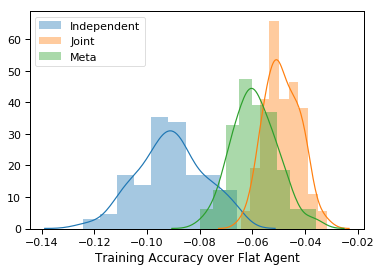

In [245]:
# Experiment 2
sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Independent')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Joint')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Meta'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Meta')
plt.legend()
plt.xlabel("Training Accuracy over Flat Agent")

d_i = training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_j = training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_m = training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Meta'), 'Accuracy'].values -\
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values
# print p_i, p_j, p_m
d_i.sort()
d_j.sort()
d_m.sort()

n = len(d_i)
print "Indep Mean={}, 95% HDI = [{}, {}]".format(d_i.mean(), d_i[int(np.floor(n * 0.025))], d_i[int(np.ceil(n * 0.975))]) 
print "Joint Mean={}, 95% HDI = [{}, {}]".format(d_j.mean(), d_j[int(np.floor(n * 0.025))], d_j[int(np.ceil(n * 0.975))]) 
print "Meta  Mean={}, 95% HDI = [{}, {}]".format(d_m.mean(), d_m[int(np.floor(n * 0.025))], d_m[int(np.ceil(n * 0.975))])



Indep Mean=-0.0112518796992, 95% HDI = [-0.018984962406, -0.00263157894737]
Joint Mean=-0.00621052631579, 95% HDI = [-0.0105263157895, -0.00213032581454]
Meta  Mean=-0.00800250626566, 95% HDI = [-0.012656641604, -0.00231829573935]


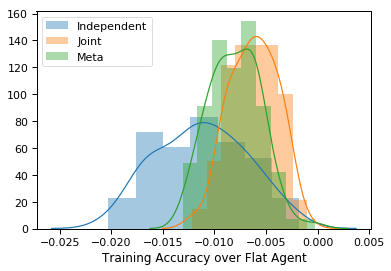

In [246]:
# Experiment 2
sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Independent')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Joint')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Meta'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Meta')
plt.legend()
plt.xlabel("Training Accuracy over Flat Agent")

d_i = training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_j = training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_m = training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Meta'), 'Accuracy'].values -\
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values
# print p_i, p_j, p_m
d_i.sort()
d_j.sort()
d_m.sort()

n = len(d_i)
print "Indep Mean={}, 95% HDI = [{}, {}]".format(d_i.mean(), d_i[int(np.floor(n * 0.025))], d_i[int(np.ceil(n * 0.975))]) 
print "Joint Mean={}, 95% HDI = [{}, {}]".format(d_j.mean(), d_j[int(np.floor(n * 0.025))], d_j[int(np.ceil(n * 0.975))]) 
print "Meta  Mean={}, 95% HDI = [{}, {}]".format(d_m.mean(), d_m[int(np.floor(n * 0.025))], d_m[int(np.ceil(n * 0.975))])


